# Twitter US Airline Sentiment

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/FastAI-Code-Collection/blob/v1/Twitter_US_Airline_Sentiment.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/FastAI-Code-Collection/blob/v1/Twitter_US_Airline_Sentiment.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

In [1]:
!pip install fastai==1.0.61

In [2]:
from fastai.text import *

## Dataset

In [3]:
# Install Kaggle API
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 4.3MB/s 
     |████████████████████████████████| 5.3MB 13.3MB/s 
     |████████████████████████████████| 112kB 58.0MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 133kB 59.5MB/s 


In [4]:
# only for google colab
import os
os.environ['KAGGLE_USERNAME'] = "<username>" 
os.environ['KAGGLE_KEY'] = "<key>"

In [5]:
path = Config.data_path()/'twitter-sentiment'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/twitter-sentiment')

In [6]:
! kaggle datasets download crowdflower/twitter-airline-sentiment -p "{path}" --unzip

  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 84.1MB/s]


In [7]:
df = pd.read_csv(path/'Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [8]:
train_df, valid_df = df.loc[:12000,:], df.loc[12000:,:]
len(train_df), len(valid_df)

(12001, 2640)

In [9]:
data_lm = TextLMDataBunch.from_df(Path(path), train_df, valid_df, text_cols=10, bs=32)
data_clas = TextClasDataBunch.from_df(Path(path), train_df, valid_df, text_cols=10, label_cols=1, bs=32)

In [10]:
data_lm.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,"about it xxbos @virginamerica seriously would pay $ 30 a flight for seats that did n't have this playing . \n it 's really the only bad thing about flying xxup va xxbos @virginamerica yes , nearly every time i fly xxup vx this “ xxunk xxunk ” wo n’t go away :) xxbos @virginamerica xxmaj really missed a prime opportunity for xxmaj men xxmaj without xxmaj hats xxunk"
1,"only you guys were starting those flights at the end of the month ! xxmaj guess i ’m still road tripping on xxmaj feb 27 … xxbos @virginamerica thanks for that . xxmaj been needing a way to make those xxmaj austin trips from xxup dca , and now you 've come through ! xxbos @virginamerica announced xxmaj new xxmaj route to xxmaj austin w / fares from $ 39"
2,. xxmaj delhi call centers . xxmaj poor xxmaj united staff spread thin and stressed . xxmaj you name it . xxbos @united xxmaj yes . xxmaj does n't make that mistake any less absurd . xxmaj does n't change the fact that i 'm very xxunk missing my luggage tonight . xxbos @united i 'm constantly having challenges with upgrades & & charges . xxmaj in order to prevent
3,"xxbos @united , and now while waiting for new pilot the door on plane xxup broke . why am i global services status on an airline that 's unsafe ? xxup stunning xxbos @united xxmaj how do i get reimbursed for hotel and taxis for the xxmaj cancelled xxmaj flightation ? xxbos @united xxmaj awesome flight crew on xxup xxunk , re the plane , the xxmaj xxunk period called"
4,xxmaj flight 2 is 2:30 hrs delayed so far b / c of xxmaj late xxmaj flight crew . xxmaj now we are literally waiting while they have dinner xxunk . to honest gate agent . xxbos @united many people on xxmaj xxunk are going to miss connections due to long wait time in xxup sfo tarmac . xxmaj seriously u ca n't find an empty gate ? xxbos @united


In [11]:
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @usairways xxup fuk u xxup us xxup airways xxup with xxup yo xxup shitty xxup chicken xxup xxunk xxup sandwich xxup that xxup so xxup overpriced xxup and u xxup xxunk xxup make xxup me xxup wait xxup in a 6 xxup hr xxup layover xxup fuk u xxup and,negative
"xxbos @southwestair xxmaj loved one 's flight xxup atl to xxup ind xxmaj cancelled xxmaj flightled due to "" ice in xxmaj indy "" . xxmaj sitting here in xxmaj indy , it is xxunk dry . xxmaj tomorrow 4 - 6 "" of snow .",negative
xxbos @usairways i wish we were on our way . xxmaj now there 's a problem w / de - icing . xxmaj three & & 1 / 2 hour delay so far & & xxunk not sure if we 'll be taking off .,negative
"xxbos @united xxmaj cancelled xxmaj flights flt from xxup ewr . "" xxmaj no xxunk . xxmaj tells wife & & 4 yr old to "" get to xxup ny to catch @aircanada "" to xxup yyz ! xxmaj good # customerservice is dead .",negative


## Language model

In [12]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


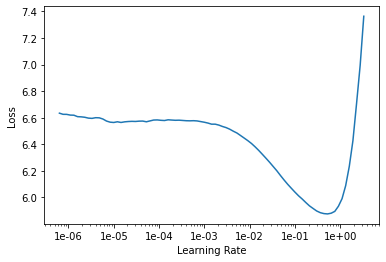

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.347726,4.068769,0.243854,00:09


In [15]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


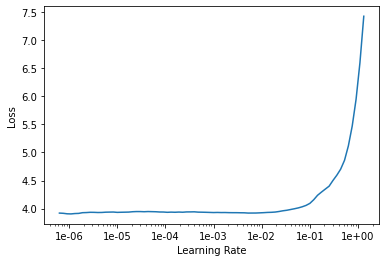

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.848779,3.938705,0.263557,00:11
1,3.705319,3.825630,0.273542,00:11
2,3.524468,3.769962,0.279896,00:11
3,3.258239,3.772595,0.283750,00:11
4,2.927369,3.831324,0.280357,00:11
5,2.579035,3.924995,0.279643,00:11
6,2.254662,4.036139,0.277187,00:11
7,2.025963,4.109713,0.274196,00:11
8,1.857660,4.180104,0.271458,00:11
9,1.797330,4.199901,0.271577,00:11


In [18]:
learn.save('twitter-sentiment-lm')

Testing our language model

In [19]:
TEXT = "I liked "
N_WORDS = 40
N_SENTENCES = 2

In [20]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked  my mobile app . It says u 're now on hold for over an hr . Ca n't change flight . What 's up ? xxbos @jetblue i 'm flying with you guys , and you guys
I liked  . Thanks ! xxbos @usairways tried completely scanned bag drop off flight 1971 , initial i sat on for 45 min then disconnected xxbos @usairways that was supposed to make it to Newark Cancelled Flightled earlier


In [21]:
learn.save_encoder('twitter-sentiment-enc')

## Classifier

In [22]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.3)
learn.load_encoder('twitter-sentiment-enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (12001 items)
x: TextList
xxbos @virginamerica xxmaj what xxunk said .,xxbos @virginamerica plus you 've added commercials to the experience ... xxunk .,xxbos @virginamerica i did n't today ... xxmaj must mean i need to take another trip !,xxbos @virginamerica it 's really aggressive to blast obnoxious " entertainment " in your guests ' faces & & they have little recourse,xxbos @virginamerica and it 's a really big bad thing about it
y: CategoryList
neutral,positive,neutral,negative,negative
Path: /root/.fastai/data/twitter-sentiment;

Valid: LabelList (2640 items)
x: TextList
xxbos @americanair xxmaj you xxmaj cancelled xxmaj flight my flight and there ’s no way to rebook on the website or app ? i have to wait 35 minutes on hold ? # fail cc @delta,xxbos @americanair i thought all those planes were xxunk ? # xxup xxunk,xxbos xxmaj just got off the phone @americanair customer service . xxmaj only 8 minutes to get my issue xxunk . xxma

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


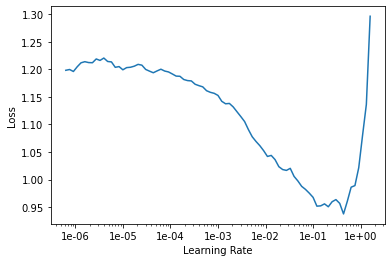

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.639272,0.457277,0.827273,00:06


In [25]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.594777,0.444001,0.837121,00:07


In [26]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.524237,0.400698,0.853030,00:11


In [27]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.396756,0.387561,0.849621,00:15
1,0.352852,0.404111,0.849621,00:16


In [28]:
print(learn)

RNNLearner(data=TextClasDataBunch;

Train: LabelList (12001 items)
x: TextList
xxbos @virginamerica xxmaj what xxunk said .,xxbos @virginamerica plus you 've added commercials to the experience ... xxunk .,xxbos @virginamerica i did n't today ... xxmaj must mean i need to take another trip !,xxbos @virginamerica it 's really aggressive to blast obnoxious " entertainment " in your guests ' faces & & they have little recourse,xxbos @virginamerica and it 's a really big bad thing about it
y: CategoryList
neutral,positive,neutral,negative,negative
Path: /root/.fastai/data/twitter-sentiment;

Valid: LabelList (2640 items)
x: TextList
xxbos @americanair xxmaj you xxmaj cancelled xxmaj flight my flight and there ’s no way to rebook on the website or app ? i have to wait 35 minutes on hold ? # fail cc @delta,xxbos @americanair i thought all those planes were xxunk ? # xxup xxunk,xxbos xxmaj just got off the phone @americanair customer service . xxmaj only 8 minutes to get my issue xxunk . xxma

In [29]:
learn.predict("I really loved the flight")

(Category tensor(2), tensor(2), tensor([0.0681, 0.0159, 0.9159]))